

# Introdução

# Instalação de Pacotes

A primeira etapa do notebook é a instalação de todos os pacotes que serão usados no projeto que são o **TensorFlow** (para o desenvolvimento de redes neurais), o **OpenCV** (para análise de imagens) e **Keras** (a interface que trabalha junto com o TensorFlow).

pip install tensorflow

pip install opencv-python

pip install keras

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import numpy as np
import pandas as pd
import os

# Leitura de Imagens

Começamos com a leitura das imagens definindo o tamanho das imagens e criando os labels para **separar as imagens entre os grupos de pacientes saudáveis e doentes**. Para realizar a classificação agrupamos os pacientes com pneumonia(pastas "PNEUMONIA VIRAL" e "PNEUMONIA BACTERIA") em uma única pasta, chamada "PNEUMONIA", além da pasta "NORMAL".

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

# Carregar Dados

Em seguida, carregamos os dados de treinamento e de validação. Será feita uma ingestão dos dados em duas variáveis e iremos poder analisar todos os dados que temos.

In [3]:
train = get_training_data('treinamento')
test = get_training_data('validacao')
val = get_training_data('validacao')

<ipython-input-2-da04b5c45152>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(data)


# Visualização e Pré-Processamento de Dados

Usamos o loop abaixo para certificar que carregamos a quantidade correta de imagens para o modelo - a princípio, tínhamos 1.266 pacientes saudáveis e 3.799 pacientes infectados.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

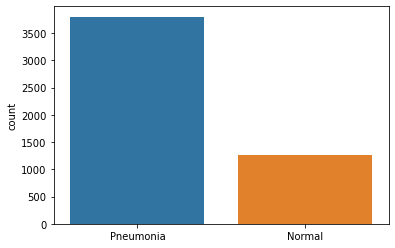

In [4]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.countplot(l) 

Os dados foram separados em duas variáveis na etapa de carregamento de dados. Logo, podemos criar as bases de treino e validação e popular elas com as imagens correspondentes.

In [5]:
x_train = []
y_train = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

x_val = []
y_val = []    

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

x_test = []
y_test = []    
    
for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

Antes de iniciarmos o processo de normalização, seria prudente pegarmos um exemplo de cada um dos grupos e ver como estão as imagens que serão usadas no modelo.

Text(0.5, 1.0, 'NORMAL')

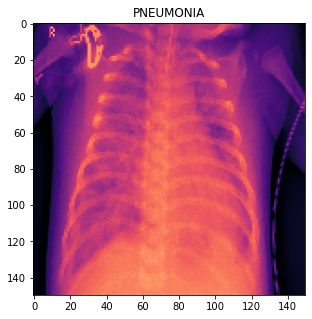

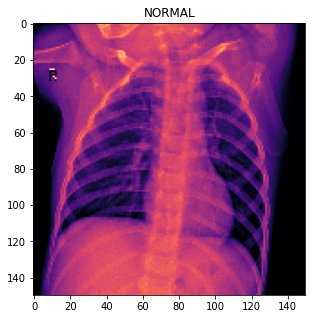

In [6]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='magma')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='magma')
plt.title(labels[train[-1][1]])

Podemos ver que existem diferenças entre as imagens de pulmões saudáveis e infectados. O próximo passo é normalizar as imagens para aproximar as quantidades das imagens de treino e validação. **O processo de normalização é importante para redes neurais no processo CNN, pois melhoram a capacidade de interpretação dos modelos**.
Neste processo, vamos também remover imagens que podem não ter qualidade apropriada para uma análise (como imagens que podem estar claras demais para análise, por exemplo).

In [7]:

x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [8]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)


In [23]:
Para utilizar técnicas de Data augmentation, invocamos a função ImageDataGenerator com os parametros "rotation_range" igual a 20,
que faz com que algumas imagens sejam rotacionadas em 50 graus, já a propriedade "zoom_range" igual a 20%, 
faz-se um zoom desse valor em algumas dessas imagens do treino, "width_shift_range" e "height_shift_range" em 5% para realizar
um shift desse valor em algumas dessas imagens e por fim realizar a rotação vertical de algumas delas.

SyntaxError: invalid syntax (<ipython-input-23-51e9f3c19dd5>, line 1)

In [9]:
data_generator = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False, 
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range = 20, 
        zoom_range = 0.2,
        width_shift_range=0.05, 
        height_shift_range=0.05, 
        horizontal_flip = False, 
        vertical_flip=True)


data_generator.fit(x_train)

Com a normalização realizada, podemos começar a construir o modelo CNN, capaz de olhar imagens e classificar elas como sendo de pacientes saudáveis ou infectados com pneumonia.
Nosso modelo é composto por quatro camadas de convoluções e duas camadas densas, sendo uma delas de saída. Utilizamos a função de ativação relu nas camadas de convolução. No otimizador utilizamos o Root Mean Square Propagation que possui learning rate padrão de 0.001 e o Binary crossentropy como loss function uma vez que ele é indicado para problemas de classificação binários.
O resultado do código abaixo será a estrutura do modelo construído.

In [10]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0

# Aplicando o Modelo

Após a criação do modelo, podemos começar a colocar nossos dados de treino e validação e medir a acurácia do modelo atual.
A variável que mais vai impactar o modelo será o "epoch"; processo que vai definir quantas vezes o dataset passa pela rede neural do projeto. Um "epoch" é passar os dados pela rede neural uma única vez. Portanto, quanto mais epochs colocamos no modelo, mais vezes os dados serão analisados.

Cada epoch tem-se a tendência de aumento da acurácia do modelo como um todo, mas irá demandar maior poder computacional e demorará mais tempo para concluir o processo. Utilizamos o método ReduceLROnPlateau para que após a métrica escolhida pare de melhorar, a nossa taxa de aprendizado seja reduzida, no caso do nosso modelo na época 4 e 7 é realizado esse procedimento. **Após testes, definimos que 8 epochs seriam apropriados para este modelo**.

In [16]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
history = model.fit(data_generator.flow(x_train,y_train, batch_size = 32) ,epochs = 8 , validation_data = data_generator.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/8
159/159 [==============================] - 233s 1s/step - loss: 0.1092 - accuracy: 0.9645 - val_loss: 0.3198 - val_accuracy: 0.8614
Epoch 2/8
159/159 [==============================] - 237s 1s/step - loss: 0.1006 - accuracy: 0.9643 - val_loss: 0.1193 - val_accuracy: 0.9277
Epoch 3/8
159/159 [==============================] - 262s 2s/step - loss: 0.0998 - accuracy: 0.9676 - val_loss: 0.1724 - val_accuracy: 0.9157
Epoch 4/8
159/159 [==============================] - 242s 2s/step - loss: 0.1129 - accuracy: 0.9643 - val_loss: 0.3853 - val_accuracy: 0.8855

Epoch 00004: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
Epoch 5/8
159/159 [==============================] - 271s 2s/step - loss: 0.0905 - accuracy: 0.9698 - val_loss: 0.1684 - val_accuracy: 0.9217
Epoch 6/8
159/159 [==============================] - 267s 2s/step - loss: 0.0974 - accuracy: 0.9672 - val_loss: 0.2028 - val_accuracy: 0.9036

Epoch 00006: ReduceLROnPlateau reducing learning rate to 8.1000000

# Resultados do Modelo e Análise Pós-Treino

In [17]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

6/6 [==============================] - 1s 183ms/step - loss: 0.5878 - accuracy: 0.8313
Loss of the model is -  0.5878212451934814
6/6 [==============================] - 1s 171ms/step - loss: 0.5878 - accuracy: 0.8313
Accuracy of the model is -  83.13252925872803 %


Usando 8 "epochs" para nosso modelo, **obtivemos uma acurácia maior que 80%**. Não é possível apresentar um valor específico pois o resultado varia cada vez que a rede neural for usada e uma aplicação das epochs for feita. Entretanto, este é um ótimo resultado para o modelo dado que é o primeiro uso do modelo após seu treinamento.
Abaixo, faremos uma comparação da acurácia dos grupos de treino e validação para cada uma das 8 "epochs" processadas:

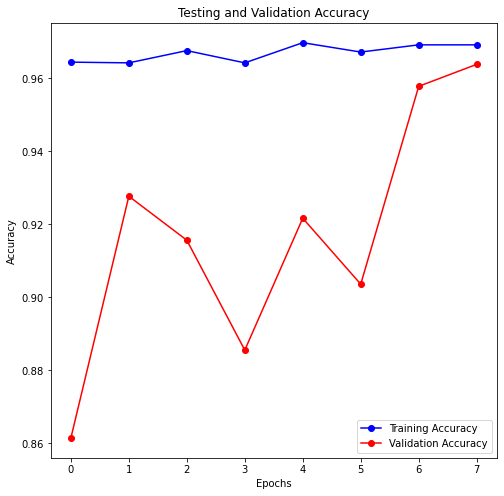

In [18]:
epochs = [i for i in range(8)]
plt.figure(figsize=(8,8))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.plot(epochs , train_acc , 'b-o' , label = 'Training Accuracy')
plt.plot(epochs , val_acc , 'r-o' , label = 'Validation Accuracy')
plt.title('Testing and Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Podemos observar acima uma grande diferença entre os dois processos; a base de treino possui valores extremamente altos, em torno de 96%. Isto pode parecer algo bom para o modelo, mas existe o risco de um potencial overfitting no modelo de treino.

O mesmo não pode ser dito para a validação do modelo, com valores altos mas que variam entre 70 e 90%. Entretanto, mesmo com esta variação, a capacidade preditiva do modelo parece ser boa a partir da primeira época. Logo, isto confirma que nosso modelo possui uma alta acurácia sem muito risco de overfitting. **Podemos dizer que nosso modelo consegue distinguir os pacientes saudáveis e doentes com um alto grau de acerto**.

Abaixo, faremos mais uma análise da performance do modelo para avaliar o **Precision**, **recall** e **f1-score** do modelo.

In [19]:
predictions = (model.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:30]

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0])

In [20]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       1.00      0.67      0.80        84
   Normal (Class 1)       0.75      1.00      0.85        82

           accuracy                           0.83       166
          macro avg       0.87      0.83      0.83       166
       weighted avg       0.87      0.83      0.83       166



A análise da capacidade preditiva do modelo nos apresenta resultados bastante otimistas, com acurácia bastante alta tanto para o grupo de pacientes saudáveis quanto para os doentes.

A precisão é o resultado percentual de verdadeiros positivos dividido pela soma dos verdadeiros positivos e falso positivos em relação ao total para ambas as classes analisadas. Nota-se que para pneumonia, a precisão ficou em torno de 99% (e em alguns casos, o valor era de 100%). Para os resultados normais, o valor foi acima de 75%, indicando que o modelo construído possui boa capacidade de identificar os resultados de verdadeiro positivo, resultando em um valor de precisão acima de 90% quando o conjunto de dados é avaliado sem separação entre as classes.

O indicador recall é o percentual de verdadeiros positivos dividido pela soma dos verdadeiros positivos e falsos negativos. Na classe de pneumonia o resultado foi de 67%, enquanto na classe normal esse resultado foi de 99%, o que indica que existem mais resultados de falso negativo na classe de pneumonia e baixo número de falso negativo na classe normal.
Por fim, o f1-score é uma medida de equilíbrio entre a precisão e o recall no modelo avaliado e é uma medida de acurácia para os testes feitos em uma classificação binária. Os resultados foram de 80% para pneumonia e 85% normal já o resultado do modelo global foi de 83%, próximo também de ambas as classes.

# Matriz de Confusão

Por fim, criaremos uma Matriz de Confusão com o objetivo de avaliar mais à fundo o desempenho do modelo desenvolvido.

<AxesSubplot:>

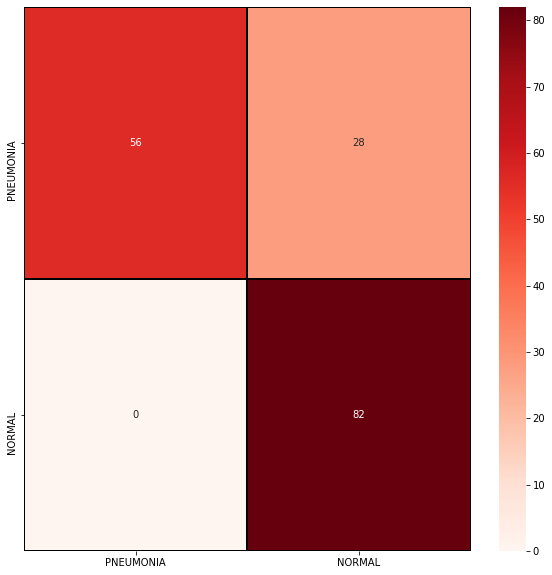

In [22]:
cm = confusion_matrix(y_test,predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Reds", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

A Matriz de Confusão desenvolvida acima com base no grupo de teste reforça os resultados obtidos anteriormente, indicando que **este modelo é eficiente na classificação de imagens em um dos dois grupos**. Obtivemos uma classificação correta em torno de 83%.
Por exemplo, em um dos casos que testamos o resultado nos retornou 56 Verdadeiro Positivos e 82 Verdadeiro Negativos de um total de 166 pacientes avaliados. **Neste caso, a classificação correta foi de 83,13%**.

É importante apontar que tivemos falso positivos (dizendo que o paciente está com pneumonia quando na verdade não está) e falsos negativos (dizendo que o paciente está saudável quando está com pneumonia). Entretanto, estes erros representavam menos que 16% dos resultados. Como os erros eram de falsos positivos; o erro mais aceitável pois dizer que um paciente está doente quando ele não está é menos crítico do que dizer que o paciente está saudável quando ele está infectado com algo que poderá ser fatal.

Logo, a Matriz de Confusão nos apresenta um modelo com um bom grau de acerto, cujos poucos erros são menos críticos do que poderiam ser.


# Conclusão

Como o diagnóstico de pneumonia é desafiador e complexo, buscamos desenvolver um modelo preditivo para auxiliar os profissionais de saúde neste processo.

Dado o grande volume e a diferença na quantidade de imagens de cada label, começamos fazendo o tratamento dos dados de teste e validação para normalizar as imagens e permitir uma análise mais precisa.
Ao aplicarmos as imagens ao modelo desenvolvido, obtivemos resultados otimistas, com um bom grau de acerto e que não apresentava sinais fortes de overfitting.
Um estudo adicional de uma matriz de confusão nos mostrou que nosso modelo possui um acerto de mais de 90% e a maioria dos erros estão concentrados em falsos positivos, um erro menos impactante do que um falso negativo.

**Sendo assim, podemos concluir que o modelo é adequado para dar suporte aos médicos durante seus diagnósticos**.